# Occupancy Prediction Model

## Software Prerequisites


Python 3+

Linux Ubuntu 16.04

## Steps should be covered :


Steps divided into following processing items that to access required python packages as well as clean, reliable
data for more accurate guess.

Principles and steps involved :
    
--Install required python packages (impyute ,sklearn, Numpy, matplotlib, xgboost,... )

--Loading Data from given CSV into Pandas Dataframe.

--Data Preparation included Data Cleaning Messy Data,....

--Data analysis and data understanding by some visualization.

--Feature extraction.

--Train and validate Regression machine learning models to estimate the Occupances for one day.

## Install Python Packages 

In [ ]:
!pip install Numpy
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install xgboost


## Loading Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier, plot_importance
from warnings import filterwarnings
filterwarnings('ignore')

## Loading Data from csv files

In [2]:
# train data
df = pd.read_csv('data/device_activations.csv')
#test data
df_sample = pd.read_csv('data/sample_solution.csv')
df.head()

,time,device,device_activated
0,2016-07-01 04:23:32,device_6,1
1,2016-07-01 06:52:57,device_2,1
2,2016-07-01 06:53:00,device_2,1
3,2016-07-01 06:56:41,device_2,1
4,2016-07-01 07:00:01,device_6,1


In [3]:
df.head()

,time,device,device_activated
0,2016-07-01 04:23:32,device_6,1
1,2016-07-01 06:52:57,device_2,1
2,2016-07-01 06:53:00,device_2,1
3,2016-07-01 06:56:41,device_2,1
4,2016-07-01 07:00:01,device_6,1


In [4]:
df.tail()

,time,device,device_activated
9040,2016-08-31 17:26:23,device_6,1
9041,2016-08-31 17:34:34,device_4,1
9042,2016-08-31 17:34:42,device_6,1
9043,2016-08-31 17:40:03,device_4,1
9044,2016-08-31 17:50:03,device_6,1


In [5]:
df.shape

(9045, 3)

In [6]:
df_sample.shape

(168, 3)

In [7]:
df_sample.head()

,time,device,activation_predicted
0,2016-09-01 00:00:00,device_1,1
1,2016-09-01 00:00:00,device_2,1
2,2016-09-01 00:00:00,device_3,1
3,2016-09-01 00:00:00,device_4,0
4,2016-09-01 00:00:00,device_5,1


In [8]:
df_sample.tail()

,time,device,activation_predicted
163,2016-09-01 23:00:00,device_3,0
164,2016-09-01 23:00:00,device_4,0
165,2016-09-01 23:00:00,device_5,0
166,2016-09-01 23:00:00,device_6,1
167,2016-09-01 23:00:00,device_7,1


## Preparing train Data

A) Check if there is null data or no?

In [9]:
df.columns[df.isnull().any()]

Index([], dtype='object')


B) Duplicated rows and entries should be removed (if
exists!!)

In [10]:
print("The number of duplicated rows", sum(df.duplicated(df.columns)))
df = df.drop_duplicates(df.columns, keep="last")
print("The number of Rows after duplicated rows removal: {}".format(df.shape))

The number of duplicated rows 54
The number of Rows after duplicated rows removal: (8991, 3)


## Data analysis 

In [11]:
df.dtypes

time                object
device              object
device_activated     int64
dtype: object

In [12]:
df['time'] = pd.DatetimeIndex(df['time'])
df.head()

,time,device,device_activated
0,2016-07-01 04:23:32,device_6,1
1,2016-07-01 06:52:57,device_2,1
2,2016-07-01 06:53:00,device_2,1
3,2016-07-01 06:56:41,device_2,1
4,2016-07-01 07:00:01,device_6,1


First, I extract feature of time.
Then, I add a feature named "min_from_midnight" to calculte the time after mid-night for each sensor.


In [13]:
df['day_of_week'] = df['time'].dt.dayofweek
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['day_of_month'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['min_from_midnight'] = df['hour']*60 + df['minute']

df.head()

,time,device,device_activated,day_of_week,hour,minute,day_of_month,month,min_from_midnight
0,2016-07-01 04:23:32,device_6,1,4,4,23,1,7,263
1,2016-07-01 06:52:57,device_2,1,4,6,52,1,7,412
2,2016-07-01 06:53:00,device_2,1,4,6,53,1,7,413
3,2016-07-01 06:56:41,device_2,1,4,6,56,1,7,416
4,2016-07-01 07:00:01,device_6,1,4,7,0,1,7,420


Some visualization for sensors help us to understand the data.

In [14]:
df.groupby(['device','day_of_week','hour']).agg({'device':np.size})

device
device   day_of_week hour        
device_1 0           7          7
                     8         15
                     9         12
                     10        16
                     11        10
                     12         9
                     13        18
                     14        17
                     15        20
                     16        27
                     17         1
         1           7         14
                     8         25
                     9         24
                     10        30
                     11        14
                     12        16
                     13        32
                     14        19
                     15        21
                     16        14
         2           7         21
                     8         33
                     9         26
                     10        28
                     11         9
                     12        23
                     13        30
                     14        32
                     15        23
...                           ...
device_7 1           13         3
                     14         4
                     15         2
                     17         1
         2           8          4
                     9          6
                     10         3
                     11         8
                     12         7
                     13         6
                     14         7
                     15         5
                     16         3
                     17         1
         3           8          3
                     9          7
                     10         9
                     11         1
                     12         5
                     13         4
                     14         6
                     15        13
                     16         3
         4           10         4
                     11         1
                     13         1
                     14         4
                     15         1
                     16         1
         6           3          1

[408 rows x 1 columns]

For example, I visualise the performance of device 6 on 2016.07.03, 2016.07.04.

In [15]:
d = df[(df.day_of_month==4) & (df.device=='device_6') & (df.month==7)]
d.describe()

,device_activated,day_of_week,hour,minute,day_of_month,month,min_from_midnight
count,31,31,31.000000,31.000000,31,31,31.000000
mean,1,0,14.516129,29.483871,4,7,900.451613
std,0,0,1.690581,17.190833,0,0,101.062304
min,1,0,12.000000,2.000000,4,7,740.000000
25%,1,0,13.000000,17.500000,4,7,832.500000
50%,1,0,14.000000,26.000000,4,7,899.000000
75%,1,0,15.500000,42.500000,4,7,960.000000
max,1,0,18.000000,59.000000,4,7,1134.000000


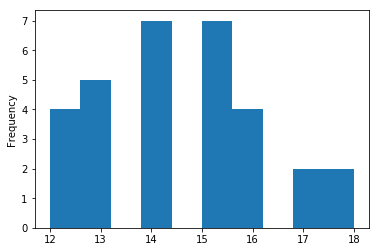

In [16]:
d.hour.plot.hist()

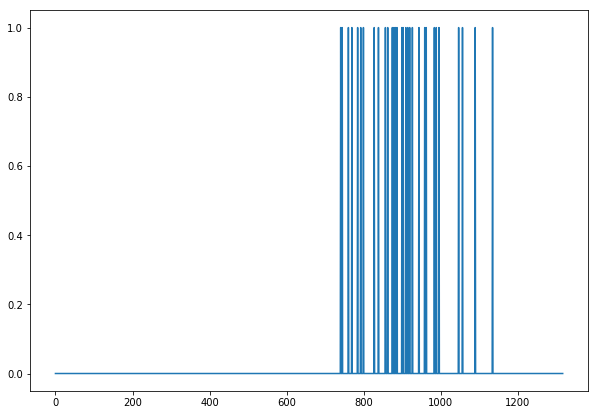

In [17]:
#calculate the frequency of sensor activation 
q = []
for i in range(1, df['min_from_midnight'].max()+1):
  q.append(len(d[(d.min_from_midnight>=i-1) & (d.min_from_midnight<i)]))
# plot the frequency of sensor activation 
plt.plot(q)
fig = plt.gcf()
fig.set_size_inches(10, 7)
plt.show()

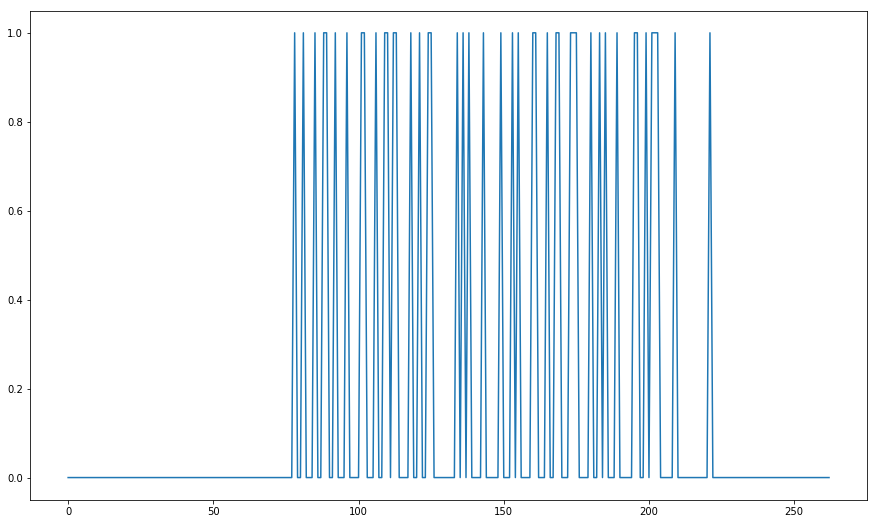

In [18]:
#calculate the frequency of sensor activation 
d = df[(df.day_of_month==5) & (df.device=='device_6') & (df.month==7)]
q = []
for i in range(5,df['min_from_midnight'].max()+1,5):
  q.append(len(d[(d.min_from_midnight>=i-5) & (d.min_from_midnight<i)]))
#plot the frequency of sensor activation 
plt.plot(q)
fig = plt.gcf()
fig.set_size_inches(15, 9)
plt.show()

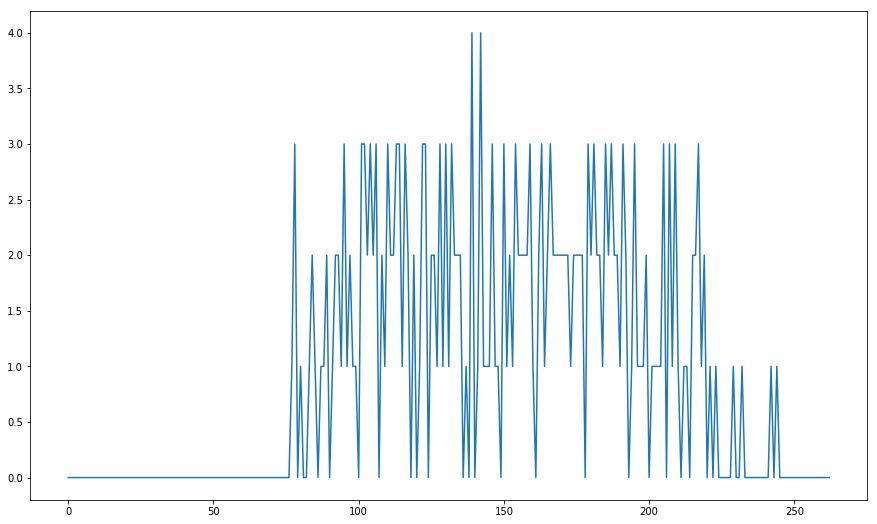

In [19]:
#calculate the frequency of sensor activation 
d = df[(df.day_of_week==3) & (df.device=='device_6') & (df.month==7)]
q = []
for i in range(5,df['min_from_midnight'].max()+1,5):
  q.append(len(d[(d.min_from_midnight>=i-5) & (d.min_from_midnight<i)]))
#plot the frequency of sensor activation 
plt.plot(q)
fig = plt.gcf()
fig.set_size_inches(15, 9)
plt.show()

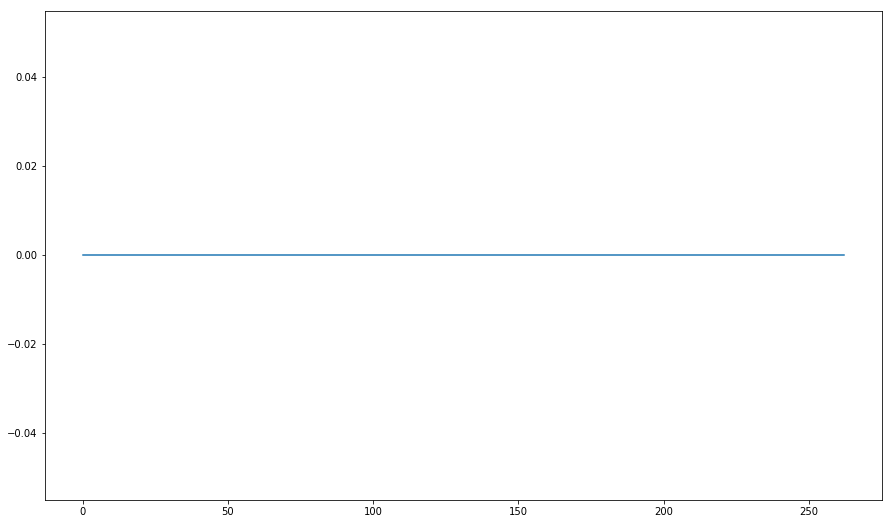

In [20]:
#calculate the frequency of sensor activation 
d = df[(df.day_of_week==5) & (df.device=='device_4') & (df.month==7)]
q = []
for i in range(5,df['min_from_midnight'].max()+1,5):
  q.append(len(d[(d.min_from_midnight>=i-5) & (d.min_from_midnight<i)]))
#plot the frequency of sensor activation 
plt.plot(q)
fig = plt.gcf()
fig.set_size_inches(15, 9)
plt.show()

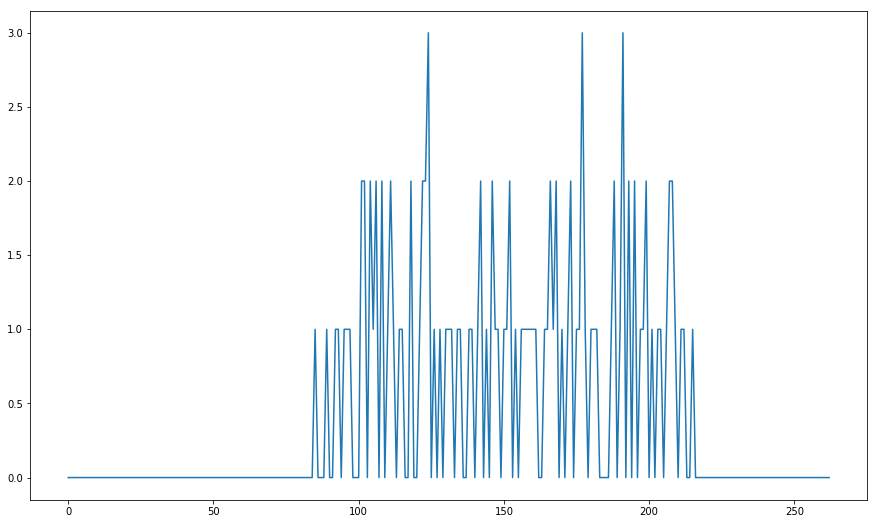

In [21]:
#calculate the frequency of sensor activation 
d = df[(df.day_of_week==3) & (df.device=='device_4') & (df.month==7)]
q = []
for i in range(5,df['min_from_midnight'].max()+1,5):
  q.append(len(d[(d.min_from_midnight>=i-5) & (d.min_from_midnight<i)]))
#plot the frequency of sensor activation 
plt.plot(q)
fig = plt.gcf()
fig.set_size_inches(15, 9)
plt.show()

## Solution

After some visualisation, I decide to consider this question as a binary classifiaction using different features of time :

class 1: when the sensors are not active.
    
class 2: when the sensors are active. 
  
So, I create a data-frame for 7 sensors during 2 months, label of each class is device_activated.
It is 0 when there is no information about sensor activity in "device_activations.csv" and 1 when the sensor are active and reported in "device_activations.csv".  

A) In this step, I create a data frame for 2 month according minute values.
First, using tmp1 and tmp2, I make a dataframe for 2 months that labels for all sensors are 0 (data). Then I join this datafram (data) and input dataframe (df) with label 1 and output datafram (data_join) are used for train and prediction.


In [22]:
date_range = pd.date_range(start="07/01/2016", end="08/31/2016", freq="T")

In [23]:
date_range.shape

(87841,)

In [24]:
tmp1 = pd.DataFrame(date_range, columns=["time"])
tmp1 = pd.concat([tmp1]*7, ignore_index=True)
tmp1.head()

,time
0,2016-07-01 00:00:00
1,2016-07-01 00:01:00
2,2016-07-01 00:02:00
3,2016-07-01 00:03:00
4,2016-07-01 00:04:00


In [25]:
tmp2_ = pd.DataFrame({"device":df["device"].unique()})
tmp2_

,device
0,device_6
1,device_2
2,device_4
3,device_3
4,device_5
5,device_7
6,device_1


In [26]:
freq = tmp1.shape[0]/7
tmp2 = pd.concat([tmp2_]*int(freq), ignore_index=True).sort_values(by="device")
tmp2.shape

(614887, 1)

In [27]:
tmp2.head()

,device
614886,device_1
416065,device_1
416072,device_1
119286,device_1
416079,device_1


In [28]:
data = tmp1.merge(tmp2, left_index=True, right_index=True)
data.head()

,time,device
614886,2016-08-31 00:00:00,device_1
416065,2016-08-14 22:21:00,device_1
416072,2016-08-14 22:28:00,device_1
119286,2016-07-22 20:05:00,device_1
416079,2016-08-14 22:35:00,device_1


In [29]:
data_sort =data.sort_values(by=["time", "device"])
data_sort.head()

,time,device
351364,2016-07-01,device_1
263523,2016-07-01,device_2
175682,2016-07-01,device_3
527046,2016-07-01,device_4
439205,2016-07-01,device_5


B) Devide the time to minute, hours, day_of_week,...

In [30]:
data["day_of_week"] = data["time"].dt.dayofweek
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute
data["day_of_month"] = data["time"].dt.day
data['month'] = data['time'].dt.month
data["min_from_midnight"] = data["hour"]*60 + data["minute"]

data.head()

,time,device,day_of_week,hour,minute,day_of_month,month,min_from_midnight
614886,2016-08-31 00:00:00,device_1,2,0,0,31,8,0
416065,2016-08-14 22:21:00,device_1,6,22,21,14,8,1341
416072,2016-08-14 22:28:00,device_1,6,22,28,14,8,1348
119286,2016-07-22 20:05:00,device_1,4,20,5,22,7,1205
416079,2016-08-14 22:35:00,device_1,6,22,35,14,8,1355


C) Now, the time column is removed. Becuase necessary information was extraxted.

In [31]:
data = data.drop(["time"], axis=1)
data.head()

,device,day_of_week,hour,minute,day_of_month,month,min_from_midnight
614886,device_1,2,0,0,31,8,0
416065,device_1,6,22,21,14,8,1341
416072,device_1,6,22,28,14,8,1348
119286,device_1,4,20,5,22,7,1205
416079,device_1,6,22,35,14,8,1355


In [32]:
df = df.drop(["time"], axis=1)
df.head()

,device,device_activated,day_of_week,hour,minute,day_of_month,month,min_from_midnight
0,device_6,1,4,4,23,1,7,263
1,device_2,1,4,6,52,1,7,412
2,device_2,1,4,6,53,1,7,413
3,device_2,1,4,6,56,1,7,416
4,device_6,1,4,7,0,1,7,420


In [33]:
data_join = pd.merge(data, df, 
                on=["device", "min_from_midnight", "day_of_month", "month",
                   "hour", "minute", "day_of_week"], how="left")

In [34]:
data_join.shape

(615355, 8)

In [35]:
data_join["device_activated"].fillna(0, inplace=True)

In [36]:
data_join.head()

,device,day_of_week,hour,minute,day_of_month,month,min_from_midnight,device_activated
0,device_1,2,0,0,31,8,0,0
1,device_1,6,22,21,14,8,1341,0
2,device_1,6,22,28,14,8,1348,0
3,device_1,4,20,5,22,7,1205,0
4,device_1,6,22,35,14,8,1355,0


In [37]:
data_join.device_activated.value_counts()

0    606627
1      8728
Name: device_activated, dtype: int64

In [38]:
print(data_join.isnull().sum())

device               0
day_of_week          0
hour                 0
minute               0
day_of_month         0
month                0
min_from_midnight    0
device_activated     0
dtype: int64


## Preparing Test data

In [39]:
df_sample.head()

,time,device,activation_predicted
0,2016-09-01 00:00:00,device_1,1
1,2016-09-01 00:00:00,device_2,1
2,2016-09-01 00:00:00,device_3,1
3,2016-09-01 00:00:00,device_4,0
4,2016-09-01 00:00:00,device_5,1


In [40]:
df_sample.shape

(168, 3)

In [42]:
# extract time features for test data
df_sample['time'] = pd.to_datetime(df_sample['time'], errors='coerce')

df_sample['day_of_week'] = df_sample['time'].dt.dayofweek
df_sample['hour'] = df_sample['time'].dt.hour
df_sample['minute'] = df_sample['time'].dt.minute
df_sample['day_of_month'] = df_sample['time'].dt.day
df_sample['month'] = df_sample['time'].dt.month
df_sample['min_from_midnight'] = df_sample['hour']*60 + df_sample['minute']

df_sample.head()

,time,device,activation_predicted,day_of_week,hour,minute,day_of_month,month,min_from_midnight
0,2016-09-01,device_1,1,3,0,0,1,9,0
1,2016-09-01,device_2,1,3,0,0,1,9,0
2,2016-09-01,device_3,1,3,0,0,1,9,0
3,2016-09-01,device_4,0,3,0,0,1,9,0
4,2016-09-01,device_5,1,3,0,0,1,9,0


In [44]:
df_sample.tail()

,time,device,activation_predicted,day_of_week,hour,minute,day_of_month,month,min_from_midnight
163,2016-09-01 23:00:00,device_3,0,3,23,0,1,9,1380
164,2016-09-01 23:00:00,device_4,0,3,23,0,1,9,1380
165,2016-09-01 23:00:00,device_5,0,3,23,0,1,9,1380
166,2016-09-01 23:00:00,device_6,1,3,23,0,1,9,1380
167,2016-09-01 23:00:00,device_7,1,3,23,0,1,9,1380


## Modeling, Training and Testing


After data analyses, now, I shall extract source and target domains for modeling.

X_train includes all columns except "device_activated" of train DataFrame. X_test includes all columns except "activation_predicted" of test DataFrame. And y* variables are the corresponding target Series.


Here, I will present tests for XGBoost model:



In [48]:
# Encoding the categorical variables in test and train data:
train = pd.get_dummies(data_join, columns=["device"])
test = pd.get_dummies(df_sample, columns=["device"])

In [49]:
train.dtypes

day_of_week            int64
hour                   int64
minute                 int64
day_of_month           int64
month                  int64
min_from_midnight      int64
device_activated     float64
device_device_1      float64
device_device_2      float64
device_device_3      float64
device_device_4      float64
device_device_5      float64
device_device_6      float64
device_device_7      float64
dtype: object

In [50]:
#shuffle train data
train = train.sample(frac=1)

In [51]:
# split data to featurs and target
X_train = train.drop("device_activated", axis=1)
y_train = train["device_activated"]

X_test = test.drop(["time", "activation_predicted"], axis=1)
y_test = test["activation_predicted"]
                   
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((615355, 13), (615355,), (168, 13), (168,))

In [52]:
X_test.head()

,day_of_week,hour,minute,day_of_month,month,min_from_midnight,device_device_1,device_device_2,device_device_3,device_device_4,device_device_5,device_device_6,device_device_7
0,3,0,0,1,9,0,1,0,0,0,0,0,0
1,3,0,0,1,9,0,0,1,0,0,0,0,0
2,3,0,0,1,9,0,0,0,1,0,0,0,0
3,3,0,0,1,9,0,0,0,0,1,0,0,0
4,3,0,0,1,9,0,0,0,0,0,1,0,0


In [91]:
# train xgboost model
XGB_model = XGBClassifier(eta=0.05, max_depth=5, early_stopping_rounds=5, 
                          min_chile_wieght=3, learning_rate=0.5, scale_pos_weight=28)
XGB_model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=5,
              eta=0.05, gamma=0, learning_rate=0.5, max_delta_step=0,
              max_depth=5, min_child_weight=1, min_chile_wieght=3, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=28, seed=None, silent=None,
              subsample=1, verbosity=1)

In [92]:
y_pred_train = XGB_model.predict(X_train)
print("Confusion Matrix :\n",confusion_matrix(y_train, y_pred_train))
print("Train acc:", accuracy_score(y_train, y_pred_train))
print("Train auc", roc_auc_score(y_train, y_pred_train))

Confusion Matrix :
 [[525430  81197]
 [   498   8230]]
Train acc: 0.8672392358882272
Train auc 0.9045461471463512


In [93]:
y_pred_test = XGB_model.predict(X_test)
print("Confusion Matrix :\n",confusion_matrix(y_test, y_pred_test))
print("Train acc:", accuracy_score(y_test, y_pred_test))
print("Train auc", roc_auc_score(y_test, y_pred_test))


Confusion Matrix :
 [[70 14]
 [63 21]]
Train acc: 0.5416666666666666
Train auc 0.5416666666666667


## Future Work

Are there any points you could think of that could help improve your result (e.g. what if you had more data)?

There are some points that help us to improve the results:
    
--Improving train dataset and information about sensors (more features).

--Apply Feature selection algorithm to filter most significant features -Compares importance of attributes -Non-
predictive parameters -Feature ranking ( with recursive feature elimination, ... ).

--Invest on Hyper-parameter optimization and parameter tuning.

--Invest on lightgbm model.

--Invest on NN deep learning for regression.

--Invest on LSTM models for time series forecasting.